In [1]:
kitti_path = '/scratch/local/hdd/hizkia/kitti'

In [2]:
from BundleGenerator import BundleGenerator
from DatasetGenerator import *

In [3]:
generator = BundleGenerator(kitti_path).load()

In [4]:
data = next(generator)

In [114]:
get_valid_boxes(data.boxes, (320, 1024))

0
.....
1
.....
2
.....
3
3
.....
4
.....
5
5
.....
6
6
.....
7
.....
8
.....


[[146, 258, 198, 338],
 [153, 338, 186, 386],
 [154, 389, 175, 420],
 [150, 442, 168, 461],
 [147, 597, 158, 615],
 [151, 490, 159, 505]]

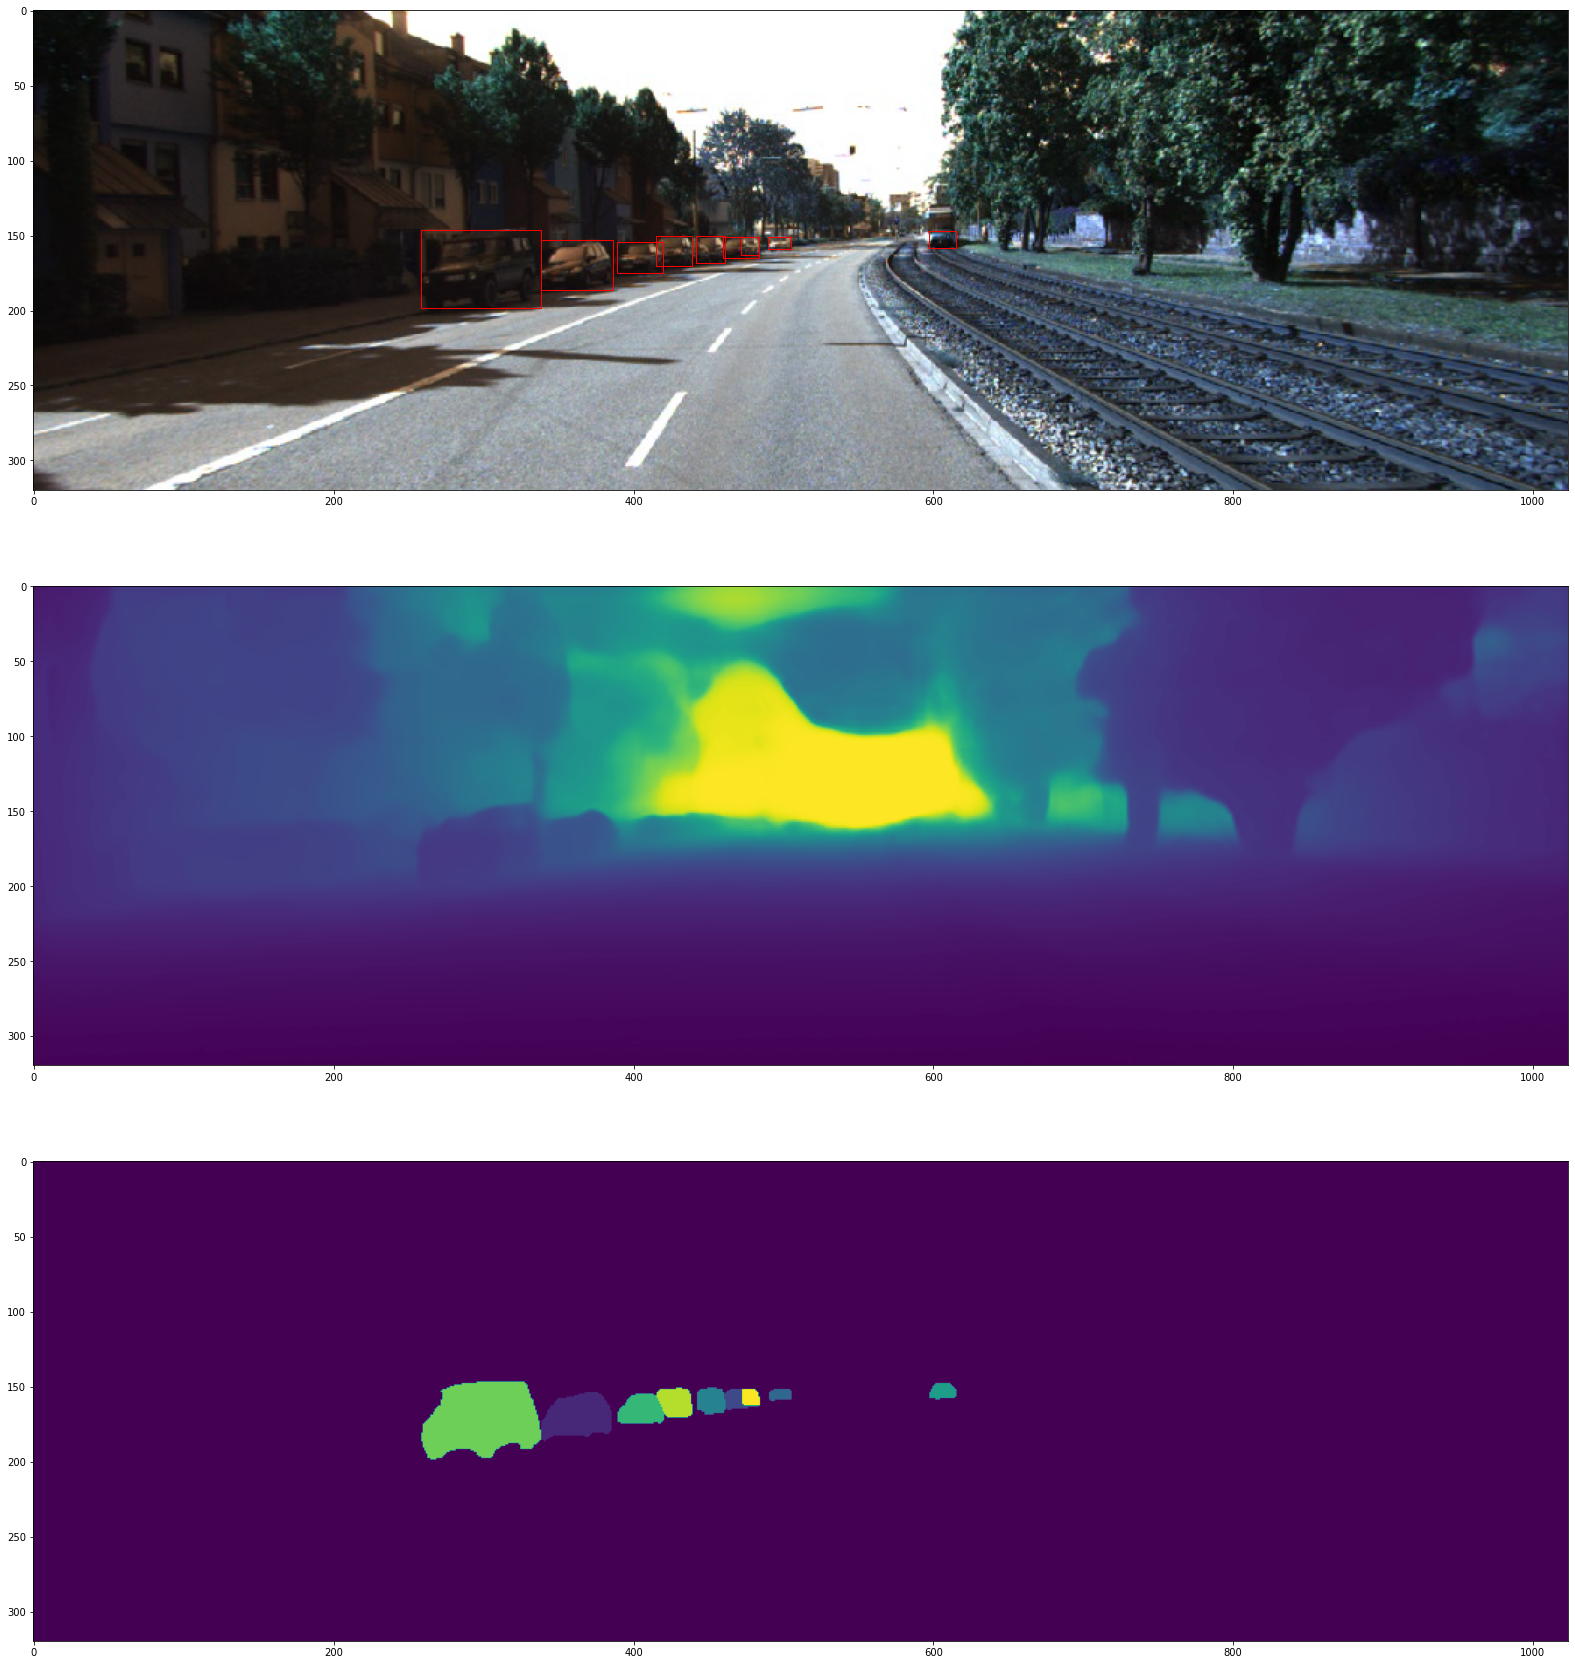

In [76]:
data.plot()